# NLP with Yelp Reviews

Let's see if we can predict whether a given Yelp review will have either 1 or 5 stars, given the text content of the review. It's not a terribly realistic job, but it'll do well enough to demonstrate setting up a natural language processing pipeline.

In [1]:
import numpy as np
import pandas as pd

In [2]:
yelp = pd.read_csv('yelp.csv')

In [3]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
business_id    10000 non-null object
date           10000 non-null object
review_id      10000 non-null object
stars          10000 non-null int64
text           10000 non-null object
type           10000 non-null object
user_id        10000 non-null object
cool           10000 non-null int64
useful         10000 non-null int64
funny          10000 non-null int64
dtypes: int64(4), object(6)
memory usage: 781.3+ KB


In [4]:
yelp.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [20]:
yelp['text'][0]

'My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.\r\n\r\nDo yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I\'ve ever had.  I\'m pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.\r\n\r\nWhile EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I\'ve ever had.\r\n\r\nAnyway, I can\'t wait to go back!'

In [5]:
yelp.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


Knowing the length is going to be useful down the line, so let's assign that value to a column now so we can get it easily later when we need to.

In [6]:
yelp = yelp.assign(length = yelp['text'].apply(len))
yelp.head(1)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,895


## Poking Around

Let's make a few plots and see what insights we can garner from them.

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('white')

Use seaborn's `FacetGrid` to make a group of five histograms wherein we can plot the lengths of the reviews for each star rating.

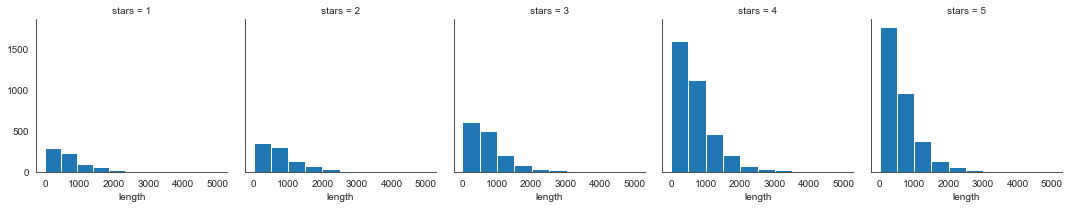

In [8]:
g = sns.FacetGrid(yelp, col='stars').map(plt.hist, 'length')

All we can see from here is that there are quite a few more 4 and 5-star reviews than any other level. Either this sample is not a good representation or people are more likely to leave a review when they like a place. How about a box plot?

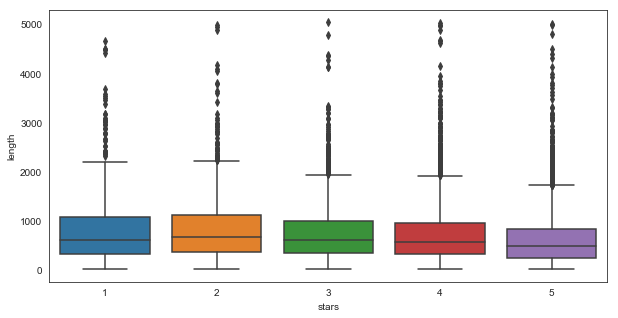

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.boxplot(data=yelp, y='length', x='stars')
plt.show()

Just eyeballing it suggests that message length might not vary as a function of review score. But we're statisticians here, so let's be more formal than that. Were the data normally-distributed we could do perform a one-way ANOVA, but since it is not, we'll have to do a Kruskal-Wallis H-test and sacrifice a little power along the way.

In [48]:
import scipy.stats as stats

groups = []
for g in [1, 2, 3, 4, 5]:
    group = yelp.loc[yelp['stars']==g]['length']
    groups.append(group)

stats.kruskal(*groups)

KruskalResult(statistic=153.15699258235875, pvalue=4.2866989609324845e-32)

Turns out there a statistically significant difference among the means after all. Some post-hoc tests would be necessary to tease them out, however.

Now, although we've already seen this from the histograms above, let's make a bar plot of the number of reviews for each review score.

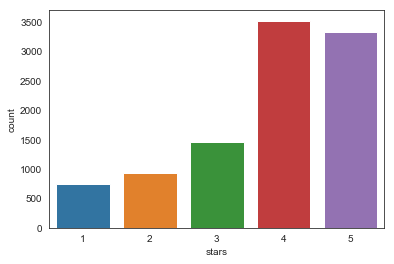

In [10]:
fig, ax = plt.subplots()
ax = sns.countplot(data=yelp, x='stars')
plt.show()

Like, I said, there are far more high-scoring reviews. Come to think of it, there's a third possibilty for this distribution. Businesses (especiialy restaurants, we can assume) that are very likely to get good reviews will also tend to get more customers, who will then be available to write more reviews.

We haven't used grouping very much recently, have we? Let's remedy that by grouping the Yelp dataframe by review score and using the mean as our summarizing function.

In [11]:
stars_group = yelp.groupby(by='stars').mean()
stars_group

,cool,useful,funny,length
stars,,,,
1,0.576769,1.604806,1.056075,830.244326
2,0.719525,1.563107,0.875944,846.249191
3,0.788501,1.306639,0.694730,762.325120
4,0.954623,1.395916,0.670448,716.493193
5,0.944261,1.381780,0.608631,627.976925


That's neat, but not super informative. Would a correlation matrix be useful?

In [12]:
stars_corr = stars_group.corr()
stars_corr

,cool,useful,funny,length
cool,1.000000,-0.743329,-0.944939,-0.856995
useful,-0.743329,1.000000,0.894506,0.698743
funny,-0.944939,0.894506,1.000000,0.842585
length,-0.856995,0.698743,0.842585,1.000000


Looks interesting, but humans aren't great a interpreting blocks of numbers like that, so let's make a correlation plot.

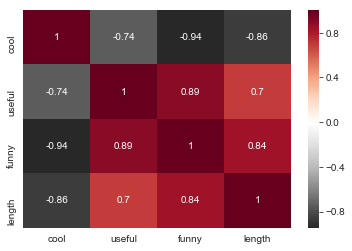

In [13]:
sns.heatmap(stars_corr, annot=True, cmap='RdGy_r', center=0)

What's up with *cool* ratings having such strong negative correlations with everything else? Interesting, nevertheless.

## NLP Classification Task

We're going to make a classifier uses the text content of a review to predict whether the score is a 1 or 5. To start with, let's create a new dataframe the consists of only 1 and 5-star reviews.

In [14]:
yelp_15 = yelp[(yelp['stars'] == 1) | (yelp['stars'] == 5)]

Let's formally define `X` as the text content of the reviews, and `y` as the stars. So, `X` is our features and `y` is our label.

In [15]:
X = yelp_15['text']
y = yelp_15['stars']

In order to make use of the text data, we must vectorize it. Import a `CountVectorizer` and use it to transform `X` into a bag of words.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

bag_transformer = CountVectorizer(stop_words='english')

Write over the `X` variable by fitting it the `bag_transformer`. Use the `fit_transform` method which, as the name suggests, combines the steps of fitting and transforming.

In [17]:
X = bag_transformer.fit_transform(X)

Farking great, this thing is.

## Modeling and Evaluation

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [50]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [52]:
from sklearn.metrics import confusion_matrix, classification_report

predictions = clf.predict(X_test)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[162  66]
 [ 34 964]]
              precision    recall  f1-score   support

           1       0.83      0.71      0.76       228
           5       0.94      0.97      0.95       998

   micro avg       0.92      0.92      0.92      1226
   macro avg       0.88      0.84      0.86      1226
weighted avg       0.92      0.92      0.92      1226



The performance isn't half bad, but I suspect we might be able to do better if we include TF-IDF.

In [58]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

steps=[('bow', CountVectorizer()),
       ('tfidf', TfidfTransformer()),
       ('classifier', MultinomialNB())]
pipeline = Pipeline(steps=steps)

X = yelp_15['text']
y = yelp_15['stars']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[  0 228]
 [  0 998]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       228
           5       0.81      1.00      0.90       998

   micro avg       0.81      0.81      0.81      1226
   macro avg       0.41      0.50      0.45      1226
weighted avg       0.66      0.81      0.73      1226



c:\users\ozbon\appdata\local\pypoetry\cache\virtualenvs\udemy-python-for-data-science-py3.6\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Well, that actually turned out to be much worse. Huh.